# **Bike Sharing System**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# 1. Install Libraries 

In [ ]:
!pip install torch==1.5.0+cu101 torchvision==0.6.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
!pip install torch-scatter==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-sparse==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-cluster==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-spline-conv==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-geometric -f https://pytorch-geometric.com/whl/torch-1.5.0.html

In [4]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
import os
from os import listdir, makedirs, remove
import os.path as osp
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from numpy.random import Generator, PCG64
from torch_geometric.data import Dataset, DataLoader
from torch_geometric.data import Data
import torch.nn.functional as funct
from torch_geometric.nn import GCNConv, TAGConv
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


## Graph Structure

In [6]:
def create_torch_data(source_data_files, station_exclusion, time_id_bounds, 
                      time_input_number, time_forward_pred, sample_size, t_shuffle, 
                      store_dir, time_int):
  
  edge_index, edge_attr, station_id_2_node_id_map = make_edges(station_exclusion, time_int)
  processed_file_names = []
  for raw_file_name in source_data_files:
    df = pd.read_csv(raw_file_name)
    # Apply filters on data to situate in the graph
    if not station_exclusion is None:
      df = df.loc[~df['station_id'].isin(station_exclusion)]
    if not time_id_bounds is None:
      df = df.loc[(df['time_id'] >= time_id_bounds[0]) & \
                  (df['time_id'] <= time_id_bounds[1])]
    # In the event that filters removed all data, jump to next iteration 
    if len(df) == 0:
      continue

    slice_generator = time_windows(df, sample_size,t_shuffle, time_input_number, time_forward_pred,
                                   station_id_2_node_id_map, t_start=df['time_id'].min(),
                                   t_end=(df['time_id'].max() - time_input_number - time_forward_pred))

    for count, (data_g_xt, data_g_yt) in enumerate(slice_generator):
      data_graph = Data(x=torch.tensor(data_g_xt, dtype=torch.float),
                        y=torch.tensor(data_g_yt, dtype=torch.float),
                        edge_index=edge_index, edge_attr=edge_attr)
      torch.save(data_graph,  store_dir + '/time_slice' + '_{}.pt'.format(count))
      processed_file_names.append('{}_{}.pt'.format('time_slice', count))

  return station_id_2_node_id_map


In [7]:
def time_windows(df, sample_size,t_shuffle, time_input_number, 
                 time_forward_pred, station_id_2_node_id_map,t_start, t_end):

  stride = None
  if sample_size is None and t_shuffle is False:
      t_val_iter = range(t_start, t_end)
  
  elif (not sample_size is None) and t_shuffle:
      seed_rg = rg = Generator(PCG64())
      t_val_iter = seed_rg.choice(range(t_start, t_end), size=sample_size, replace=False)
    
  null_list = [0] * time_input_number
  for t_val in t_val_iter:
    df_x = df.loc[(df['time_id'] < t_val + time_input_number) & (df['time_id'] >= t_val)]
    df_y = df.loc[df['time_id'] == t_val + time_input_number + time_forward_pred - 1]

    if len(df_x) == 0 or len(df_y) == 0:
      raise RuntimeError('Encountered missing time period')

    # Move from pandas to torch tensor compatible data
    data_xt = [[null_list, null_list]] * len(station_id_2_node_id_map)
    for station_id, chunk in df_x.groupby('station_id'):
      ind = station_id_2_node_id_map[station_id]
      data_xt[ind] = [chunk['arrivals'].tolist(),chunk['departures'].tolist()]

    data_yt = [[0, 0]] * len(station_id_2_node_id_map)
    for station_id, chunk in df_y.groupby('station_id'):
      ind = station_id_2_node_id_map[station_id]
      data_yt[ind] = [chunk['arrivals'].item(), chunk['departures'].item()]

    yield data_xt, data_yt

  

In [9]:
def make_edges(station_exclusion, time_int):

  df_gw = pd.read_csv('/content/drive/My Drive/data_int_{}/graph_weight.csv'.format(time_int))
  df_gw['StartStation Id'] = df_gw['StartStation Id'].astype(int)
  df_gw['EndStation Id'] = df_gw['EndStation Id'].astype(int)
  df_gw['weight'] = df_gw['average_percent'].astype(float)
  df_gw = df_gw[['StartStation Id', 'EndStation Id', 'weight']]

  if not station_exclusion is None:
    df_gw = df_gw.loc[~df_gw['StartStation Id'].isin(station_exclusion)]
    df_gw = df_gw.loc[~df_gw['EndStation Id'].isin(station_exclusion)]

# Create map between station ids and node id, needed because Pytorch geometric reindex nodes
  all_ids = set(df_gw['StartStation Id'].unique()).union(set(df_gw['EndStation Id'].unique()))
  node_id_2_station_id_map = dict((n, sid) for n, sid in enumerate(all_ids))
  station_id_2_node_id_map = {v: k for k, v in node_id_2_station_id_map.items()}

  df3 = df_gw
  # Put data in format expected by Pytorch
  index = torch.tensor([[station_id_2_node_id_map[k] for k in df3['StartStation Id']],
                        [station_id_2_node_id_map[k] for k in df3['EndStation Id']]], dtype=torch.long)
  attr = torch.tensor(df3['weight'].tolist(), dtype=torch.float)

  return index, attr, station_id_2_node_id_map

Train Data

In [10]:
#Set an time interval
time_int = 60

In [ ]:
#For 30 min intervals run this cell
source_data_files=['/content/drive/My Drive/data_int_30/data_reformat_0.csv',
                   '/content/drive/My Drive/data_int_30/data_reformat_1.csv',
                   '/content/drive/My Drive/data_int_30/data_reformat_2.csv',
                   '/content/drive/My Drive/data_int_30/data_reformat_3.csv']
source_graph_file= '/content/drive/My Drive/data_int_30/graph_weight.csv'


In [11]:
# For 60 min interval interval
source_data_files=['/content/drive/My Drive/data_int_60/data_reformat_0.csv',
                   '/content/drive/My Drive/data_int_60/data_reformat_1.csv',
                   '/content/drive/My Drive/data_int_60/data_reformat_2.csv',
                   '/content/drive/My Drive/data_int_60/data_reformat_3.csv']
source_graph_file= '/content/drive/My Drive/data_int_60/graph_weight.csv'

In [12]:
data_dir = '/content/process_files'
os.mkdir(data_dir)
time_shuffle=True
sample_size= 400
create_from_source=True
ntimes_leading=9
ntimes_forward=4
station_exclusion=[3000, 4286,4285]
time_id_bounds=(0, 7315)

station2id = create_torch_data(source_data_files, station_exclusion, time_id_bounds, 
                               ntimes_leading, ntimes_forward, sample_size, time_shuffle, 
                               data_dir, time_int)

In [13]:
datalist = []
for file in listdir(data_dir):
  data = torch.load(data_dir+'/'+file)
  datalist.append(data)

Test Data

In [16]:
data_dir = '/content/test_files'
os.mkdir(data_dir)
sample_size= 200
create_from_source=True
ntimes_forward=1
time_id_bounds=(7315,8759)

station2id_test = create_torch_data(source_data_files, station_exclusion, time_id_bounds, 
                               ntimes_leading, ntimes_forward, sample_size, time_shuffle, 
                               data_dir, time_int)

In [17]:
testlist = []
for file in listdir(data_dir):
  test_data = torch.load(data_dir+'/'+file)
  testlist.append(test_data)

GCN Model

In [18]:
# Set a convention on input data tensor axes semantics
IDX_CHANNEL = 1
IDX_SPATIAL = 0
IDX_TEMPORAL = 2

In [19]:
class SpatioTemporal(torch.nn.Module):
  def __init__(self, n_spatial, n_temporal, channel_inputs, channel_outputs):
    super(SpatioTemporal, self).__init__()
    self.n_spatial = n_spatial
    self.n_temporal = n_temporal
    self.channel_inputs = channel_inputs
    self.channel_outputs = channel_outputs

In [20]:
class Time1dConvGLU(SpatioTemporal):
  def __init__(self, n_spatial, n_temporal, channel_inputs, channel_outputs, time_convolution_length):
    super(Time1dConvGLU, self).__init__(n_spatial, n_temporal, channel_inputs, channel_outputs)
    self.one_d_conv_1 = torch.nn.Conv1d(in_channels=self.channel_inputs,
                                        out_channels=2 * self.channel_outputs,
                                        kernel_size=time_convolution_length,
                                        groups=1)
    n_temporal_out = self.n_temporal - time_convolution_length + 1
    assert n_temporal_out > 0

  def forward(self, x):
    total = []
    for k_node, tensor_node in enumerate(x.split(1, dim=IDX_SPATIAL)):
      pq_out = self.one_d_conv_1(tensor_node)
      y_conv_and_gated_out = F.glu(pq_out, dim=1)
      total.append(y_conv_and_gated_out)

    nodes_spatial = torch.cat(total, dim=IDX_SPATIAL)
    return nodes_spatial

In [21]:
class SpatialGraphConv(SpatioTemporal):
  def __init__(self, n_spatial, n_temporal, channel_inputs, channel_outputs, graph_conv_kwargs):
    super(SpatialGraphConv, self).__init__(n_spatial, n_temporal, channel_inputs, channel_outputs)

    self.gcn = GCNConv(self.channel_inputs, self.channel_outputs)

  def forward(self, data):
    assert self.channel_inputs == data.x.shape[IDX_CHANNEL]
    x_s = data.x
    total = []
    for k_t in range(data.x.shape[IDX_TEMPORAL]):
      x_t = x_s[:,:,k_t]
      y_t = self.gcn(x_t, data.edge_index, data.edge_attr)
      y_t = F.relu(y_t)
      total.append(y_t)

    nodes_times = torch.stack(total, dim=IDX_TEMPORAL)
    return nodes_times

In [22]:
class STGCN(torch.nn.Module):
  def __init__(self, n_temporal_dim, n_spatial_dim, n_input_channels,
               co_temporal=64, co_spatial=16, time_conv_length=3,
               graph_conv_kwargs={}):
    super(STGCN, self).__init__()

    self.n_temporal = n_temporal_dim
    self.n_spatial = n_spatial_dim
    self.n_input_channels = n_input_channels
    self.co_temporal = co_temporal
    self.co_spatial = co_spatial

    self.permute_norm = (IDX_CHANNEL, IDX_SPATIAL, IDX_TEMPORAL)
    assert n_temporal_dim - 4 * time_conv_length + 4 == 1

    self.model_t_1a = Time1dConvGLU(n_spatial_dim, n_temporal_dim,
                                    channel_inputs=n_input_channels,
                                    channel_outputs=co_temporal,
                                    time_convolution_length=time_conv_length)
    self.model_s_1 = SpatialGraphConv(n_spatial_dim, n_temporal_dim - time_conv_length + 1,
                                      channel_inputs=co_temporal,
                                      channel_outputs=co_spatial,
                                      graph_conv_kwargs=graph_conv_kwargs)
    self.model_t_1b = Time1dConvGLU(n_spatial_dim, n_temporal_dim - time_conv_length + 1,
                                    channel_inputs=co_spatial,
                                    channel_outputs=co_temporal,
                                    time_convolution_length=time_conv_length)
    self.layer_norm_1 = torch.nn.LayerNorm([n_spatial_dim, n_temporal_dim - 2 * time_conv_length + 2])

    self.model_t_2a = Time1dConvGLU(n_spatial_dim, n_temporal_dim - 2 * time_conv_length + 2,
                                    channel_inputs=co_temporal,
                                    channel_outputs=co_temporal,
                                    time_convolution_length=time_conv_length)
    self.model_s_2 = SpatialGraphConv(n_spatial_dim, n_temporal_dim - 3 * time_conv_length + 3,
                                      channel_inputs=co_temporal,
                                      channel_outputs=co_spatial,
                                      graph_conv_kwargs=graph_conv_kwargs)
    self.model_t_2b = Time1dConvGLU(n_spatial_dim, n_temporal_dim - 3 * time_conv_length + 3,
                                    channel_inputs=co_spatial,
                                    channel_outputs=co_temporal,
                                    time_convolution_length=time_conv_length)
    self.layer_norm_2 = torch.nn.LayerNorm([n_spatial_dim, n_temporal_dim - 4 * time_conv_length + 4])

    self.model_output = torch.nn.Sequential(torch.nn.Linear(in_features=n_spatial_dim * co_temporal,
                                                            out_features=n_spatial_dim * n_input_channels),
                                            torch.nn.ReLU(),
                                            torch.nn.Linear(in_features=n_spatial_dim * n_input_channels,
                                                            out_features=n_spatial_dim * n_input_channels))
  
  def forward(self, data_graph):
    data_step_0 = data_graph
    edge_index = data_graph.edge_index
    edge_attr = data_graph.edge_attr
    self.n_graphs_in_batch = self._infer_batch_size(data_step_0.x)

    data_step_0_x = data_step_0.x
    data_step_1_x = self.model_t_1a(data_step_0_x)
    data_step_1 = Data(data_step_1_x, edge_index, edge_attr)
    data_step_2_x = self.model_s_1(data_step_1)
    data_step_3_x = self.model_t_1b(data_step_2_x)
    data_step_3_x = self._compute_layer_norm(data_step_3_x, self.layer_norm_1)

    data_step_4_x = self.model_t_2a(data_step_3_x)
    data_step_4 = Data(data_step_4_x, edge_index, edge_attr)
    data_step_5_x = self.model_s_2(data_step_4)
    data_step_6_x = self.model_t_2b(data_step_5_x)
    data_step_6_x = self._compute_layer_norm(data_step_6_x, self.layer_norm_2)

    data_out_reshape = data_step_6_x.reshape(self.n_graphs_in_batch, self.n_spatial * self.co_temporal)
    data_output_x = self.model_output(data_out_reshape)
    data_output_x = data_output_x.reshape(self.n_graphs_in_batch * self.n_spatial, self.n_input_channels)

    return Data(y=data_output_x, edge_index=edge_index, edge_attr=edge_attr)

  def _infer_batch_size(self, data_x):
    if data_x.shape[IDX_SPATIAL] % self.n_spatial == 0:
      n_batches = data_x.shape[IDX_SPATIAL] // self.n_spatial

    else:
      raise RuntimeError('Incorrect batch size')

    return n_batches
  
  def _compute_layer_norm(self, data_x, norm_func):
    ret = []
    for k_batch in range(self.n_graphs_in_batch):
      data_x_pergraph = data_x.narrow(IDX_SPATIAL, k_batch * self.n_spatial, self.n_spatial)
      data_x_pergraph_norm = norm_func(data_x_pergraph.permute(self.permute_norm)).permute(self.permute_norm)
      ret.append(data_x_pergraph_norm)

    return torch.cat(ret)

Train

In [23]:
dataset_kwarg = datalist
dataloader_kwargs = {'batch_size' : 64, 'shuffle' : True}

model_kwargs = {'n_temporal_dim' : 9, 'n_input_channels' : 2,
                  'co_temporal' :64, 'co_spatial' :16, 'time_conv_length' : 3}

optimizer_kwargs = {'lr' : 0.01,
                      'momentum' : 0.9}

max_epochs = 5


In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bike_loader = DataLoader(datalist, **dataloader_kwargs)

In [25]:
model = STGCN(n_spatial_dim=datalist[0].num_nodes, **model_kwargs).to(device)
optimizer = torch.optim.SGD(model.parameters(), **optimizer_kwargs)
model.train()
stgcn_loss =[]

In [26]:
for epoch in range(max_epochs):
  print ('Epoch {} at {}'.format(epoch, datetime.now().isoformat()))
  for k_batch, local_batch in enumerate(bike_loader):
    local_batch = local_batch.to(device)
    optimizer.zero_grad()
    #out = model(local_batch)
    loss = funct.mse_loss(model(local_batch).y, local_batch.y)
    stgcn_loss.append(loss)
    loss.backward()
    optimizer.step()
    


Epoch 0 at 2020-08-16T19:25:35.543919
Epoch 1 at 2020-08-16T19:27:09.078212
Epoch 2 at 2020-08-16T19:28:42.127577
Epoch 3 at 2020-08-16T19:30:14.460583
Epoch 4 at 2020-08-16T19:31:47.721147


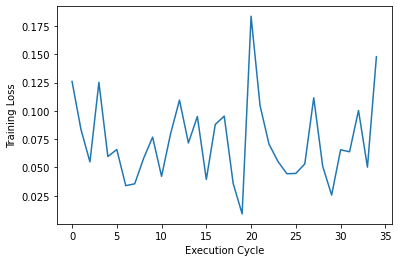

In [29]:
#Training MSE Loss
plt.plot(stgcn_loss)
plt.xlabel("Execution Cycle")
plt.ylabel("Training Loss")
plt.show()

In [30]:
#Saving the model compiled
torch.save({'max_epochs': epoch,'k_batch': k_batch,
                  'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'loss': loss},'/content/stgcn_model' + '.tar')

In [31]:
#Loading the model file 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = STGCN(n_spatial_dim=datalist[0].num_nodes, **model_kwargs).to(device)
state = torch.load('/content/stgcn_model.tar')
model.load_state_dict(state['model_state_dict'])
model.eval()
# Predicts for the station id's included in the viz station
viz_stations = [3005]

In [32]:
#Setting test parameters
dataloader_test = {'batch_size' : 10, 'shuffle' : False}
test_loader = DataLoader(testlist, **dataloader_test)

In [66]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
inds = [station2id_test[k] for k in viz_stations]
inds_slicer = [[ind * 2, ind *2 + 1] for ind in inds]
inds_slicer = torch.tensor(inds_slicer).flatten().to(device)
totals_predict = []
totals_actual = []
for n_time, data in enumerate(test_loader):
  data = data.to(device)
  predict = model(data).y
  actual = data.y
  v_predict = torch.take(predict, inds_slicer)
  v_actual = torch.take(actual, inds_slicer)
  totals_predict.extend(list(v_predict))
  totals_actual.extend(list(v_actual))



In [67]:
mind = pd.MultiIndex.from_product([['arrivals', 'departures'], range(n_time + 1), viz_stations],
                                  names=['event_type', 'local_time_id', 'station_id'])
df_1 = pd.DataFrame(totals_actual, index=mind, columns=['actual_count'])
df_2 = pd.DataFrame(totals_predict, index=mind, columns=['predicted_count'])
df = df_1.join(df_2)
print (df.head())


                                                    actual_count                                    predicted_count
event_type local_time_id station_id                                                                                
arrivals   0             3005        tensor(0., device='cuda:0')  tensor(0.0205, device='cuda:0', grad_fn=<Selec...
           1             3005        tensor(0., device='cuda:0')  tensor(0.0656, device='cuda:0', grad_fn=<Selec...
           2             3005        tensor(1., device='cuda:0')  tensor(0.7832, device='cuda:0', grad_fn=<Selec...
           3             3005        tensor(0., device='cuda:0')  tensor(0.4881, device='cuda:0', grad_fn=<Selec...
           4             3005        tensor(2., device='cuda:0')  tensor(0.5985, device='cuda:0', grad_fn=<Selec...


In [68]:
bike_demand_df = df.loc[(df.index.get_level_values('event_type') == 'arrivals')]
dock_demand_df = df.loc[(df.index.get_level_values('event_type') == 'departures')]

In [ ]:
bike_demand_df['actual_count'] = bike_demand_df['actual_count'].apply(lambda row: row.item())
bike_demand_df['predicted_count'] = bike_demand_df['predicted_count'].apply(lambda row: row.item())
dock_demand_df['actual_count'] = dock_demand_df['actual_count'].apply(lambda row: row.item())
dock_demand_df['predicted_count'] = dock_demand_df['predicted_count'].apply(lambda row: row.item())

In [70]:
bike_demand_df.reset_index(level='local_time_id', inplace=True)
dock_demand_df.reset_index(level='local_time_id', inplace=True)

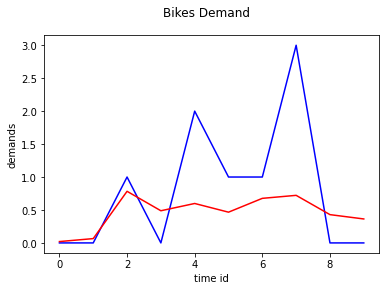

In [71]:
#Plot bikes demand
plt.plot(bike_demand_df.local_time_id[0:10], bike_demand_df.actual_count[0:10], color= 'blue') 
plt.plot(bike_demand_df.local_time_id[0:10], bike_demand_df.predicted_count[0:10], color= 'red') 
plt.xlabel('time id')
plt.ylabel('demands')
plt.suptitle('Bikes Demand')
plt.show()


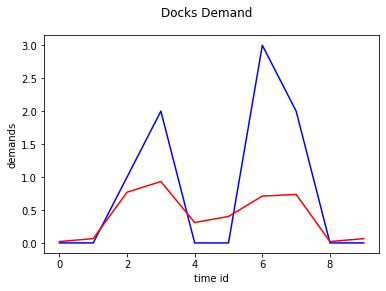

In [72]:
#Plot docks demand
plt.plot(dock_demand_df.local_time_id[0:10], dock_demand_df.actual_count[0:10], color= 'blue') 
plt.plot(dock_demand_df.local_time_id[0:10], dock_demand_df.predicted_count[0:10], color= 'red') 
plt.xlabel('time id')
plt.ylabel('demands')
plt.suptitle('Docks Demand')
plt.show()


In [64]:
print('Evaluation: Bike Demand')
print(mean_squared_error(bike_demand_df.actual_count,bike_demand_df.predicted_count))
print(mean_absolute_error(bike_demand_df.actual_count,bike_demand_df.predicted_count))
print(np.sqrt(mean_absolute_error(bike_demand_df.actual_count,bike_demand_df.predicted_count)))

Evaluation: Bike Demand
8.258668602022473
1.7906819876283406
1.3381636624973572


In [65]:
print('Evaluation: Dock Demand')
print(mean_squared_error(dock_demand_df.actual_count,dock_demand_df.predicted_count))
print(mean_absolute_error(dock_demand_df.actual_count,dock_demand_df.predicted_count))
print(np.sqrt(mean_absolute_error(dock_demand_df.actual_count,dock_demand_df.predicted_count)))

Evaluation: Dock Demand
0.702125816885262
0.5386247583664954
0.7339105928970472


In [ ]:
bike_demand_df.to_csv('stgcn_bike.csv')
dock_demand_df.to_csv('stgcn_dock.csv')